In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [4]:
print("min pixel value: ", np.min(X_train_full))
print("max pixel value: ", np.max(X_train_full))

min pixel value:  0
max pixel value:  255


In [5]:
X_train_full = X_train_full/255.
X_test = X_test/255.

In [6]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid , y_train = y_train_full[:5000], y_train_full[5000:]

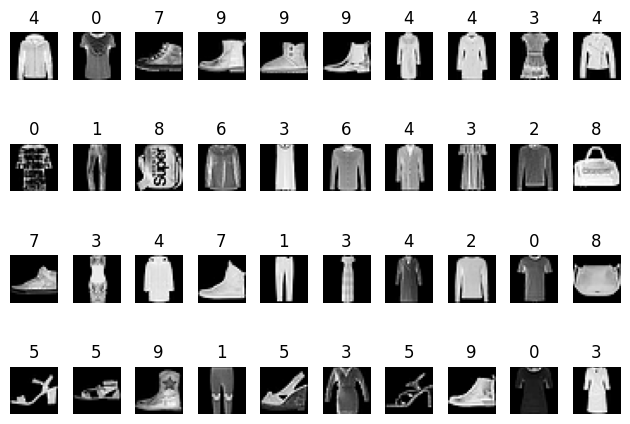

In [7]:
n_row = 4
n_col = 10

for row in range(n_row):
  for col in range(n_col):
    index = row * n_col + col
    plt.subplot(n_row, n_col, index+1)
    plt.imshow(X_train[index], cmap = "gray")
    plt.grid()
    plt.axis('off')
    plt.title(y_train[index])

plt.tight_layout()
plt.show()

# Custom LayerNormalization

In [8]:
class LayerNormalization(tf.keras.layers.Layer):
  def __init__(self, eps=0.00001, **kwargs):
    super().__init__(**kwargs)
    self.eps = eps

  def build(self, input_shape):
    self.gamma = self.add_weight(name = "gamma", shape = input_shape[-1:],
                                 initializer = "ones")
    self.beta  = self.add_weight(name = "beta", shape = input_shape[-1:],
                                 initializer = "zeros")

  def call(self, X):
    # tính trung bình theo chiều cuối cùng của X, giữ chiều là 1 ở trục cuối cùng
    mean = tf.reduce_mean(X, axis = -1, keepdims=True) # sahpe(X.shape[1], X.shape[2],1)
    variance = tf.reduce_mean(tf.square(X-mean), axis = -1, keepdims=True)

    return self.gamma * (X-mean)/ (tf.sqrt(variance+self.eps)) + self.beta

  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "gamma": self.gamma, "beta":self.beta, "eps":self.eps}

In [9]:
# so sánh kết quả với layer gốc
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.MeanAbsoluteError()(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.009379908442497253>

#Fashion Mnist with custom training loop

In [10]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [11]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [12]:
X_train.shape

(55000, 28, 28)

In [13]:
number_label = len(np.unique(y_train))
number_label

10

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(number_label, activation = 'softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
n_epochs = 10
batch_size = 32
n_steps = len(X_train)//batch_size
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
mean_loss = tf.keras.metrics.Mean(name = "mean_loss")
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [16]:
for epoch in range(1, n_epochs +1):
  print("Epoch {}/{}".format(epoch, n_epochs))
  for step in range(1, n_steps+1):
    X_batch, y_batch = random_batch(X_train, y_train)

    with tf.GradientTape() as tape:
      y_pred = model(X_batch, training= True)
      main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      loss = tf.add_n([main_loss] + model.losses)

    gradient = tape.gradient(loss, model.trainable_variables )
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    mean_loss(loss)
    for metric in metrics:
      metric(y_batch, y_pred)
    print_status_bar(step,n_steps, mean_loss, metrics)
  for metric in [mean_loss] + metrics:
    metric.reset_state()

Epoch 1/10
1718/1718 - mean_loss: 0.5021 - sparse_categorical_accuracy: 0.8249
Epoch 2/10
1718/1718 - mean_loss: 0.3792 - sparse_categorical_accuracy: 0.8647
Epoch 3/10
1718/1718 - mean_loss: 0.3384 - sparse_categorical_accuracy: 0.8780
Epoch 4/10
1718/1718 - mean_loss: 0.3075 - sparse_categorical_accuracy: 0.8888
Epoch 5/10
1718/1718 - mean_loss: 0.2991 - sparse_categorical_accuracy: 0.8909
Epoch 6/10
1718/1718 - mean_loss: 0.2790 - sparse_categorical_accuracy: 0.8972
Epoch 7/10
1718/1718 - mean_loss: 0.2689 - sparse_categorical_accuracy: 0.9012
Epoch 8/10
1718/1718 - mean_loss: 0.2558 - sparse_categorical_accuracy: 0.9050
Epoch 9/10
1718/1718 - mean_loss: 0.2471 - sparse_categorical_accuracy: 0.9074
Epoch 10/10
1718/1718 - mean_loss: 0.2409 - sparse_categorical_accuracy: 0.9110


In [17]:
val_loss = tf.keras.metrics.Mean()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
n_batches = len(X_valid)//batch_size

In [18]:
for i in range(n_batches):
    X_batch, y_batch = random_batch(X_valid, y_valid)

    # Dự đoán
    y_pred = model(X_batch, training=False)

    # Tính loss và update metrics
    loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
    val_loss.update_state(loss)
    val_accuracy.update_state(y_batch, y_pred)

# In kết quả
print("Validation Loss:", val_loss.result().numpy())
print("Validation Accuracy:", val_accuracy.result().numpy())

Validation Loss: 0.32368463
Validation Accuracy: 0.88421476
